# Detailed Analysis of Specific Scenario with Genetic Algorithm Optimization

This notebook performs a deep and detailed analysis of a specific scenario, based on the methodology of the comprehensive optimization notebook. It includes:

## 🎯 **Key Features:**
1. **Scenario selection** with best GA optimization results
2. **Detailed analysis** of coordination before vs after optimization
3. **Advanced visualizations** with bar charts, histograms and comparisons
4. **Specific TMT analysis** for the selected scenario
5. **Parameter comparison** of optimized vs initial relay settings
6. **Detailed performance metrics** per relay pair

## 📊 **Analysis Types:**
- **Pair-wise coordination**: Individual analysis of each main-backup pair
- **Time distribution**: Histograms and statistics of operating times
- **Relay improvements**: TDS and Pickup parameter comparison
- **Specific TMT**: Total Miscoordination Time analysis
- **Comparative visualizations**: Before vs after optimization

## 🔬 **Methodology:**
- Automatic selection of the best scenario based on previous results
- Loading optimized data from the main notebook
- Detailed statistical analysis
- Integrated report and graph generation


In [1]:
# %% Imports and Constants
import os
import json
import math
import random
import pandas as pd
import numpy as np
from datetime import datetime, timezone
from pathlib import Path
from typing import Dict, List, Tuple, Optional, Any
import warnings
warnings.filterwarnings('ignore')

# Plotting
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
# Enable inline plotting for Jupyter notebooks
%matplotlib inline

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)

# =============== CONSTANTS (aligned with MATLAB) ===============
K = 0.14
N = 0.02

CTI = 0.20
MIN_TDS = 0.05
MAX_TDS = 0.8
MIN_PICKUP = 0.05
MAX_PICKUP_FACTOR = 0.6
MAX_TIME = 10.0

# GA (Chu & Beasley) — Fast configuration for testing
GA_Ni = 80
GA_iterno = 1000  # Reduced for faster execution
GA_maxGen = 1000  # Reduced for faster execution
GA_nMut = 2

print("✅ Imports and constants loaded successfully")
print(f"📊 GA Parameters: Population={GA_Ni}, Max Generations={GA_maxGen}")
print(f"⚙️  Coordination: CTI={CTI}s, MIN_TDS={MIN_TDS}, MAX_TDS={MAX_TDS}")
print("🎯 Ready for specific scenario analysis")


✅ Imports and constants loaded successfully
📊 GA Parameters: Population=80, Max Generations=1000
⚙️  Coordination: CTI=0.2s, MIN_TDS=0.05, MAX_TDS=0.8
🎯 Ready for specific scenario analysis


In [2]:
# %% Utility Functions and Path Management

def setup_paths():
    """Setup all necessary paths for the project"""
    nb_dir = Path.cwd()
    
    # Robust project root detection
    if nb_dir.name == 'notebooks' and nb_dir.parent.name == 'analysis':
        project_root = nb_dir.parent.parent  # .../AutoDOC-MG
    elif nb_dir.name == 'analysis':
        project_root = nb_dir.parent
    else:
        project_root = nb_dir if (nb_dir / 'data').exists() else nb_dir.parent

    # Define all paths
    paths = {
        'project_root': project_root,
        'data_raw': project_root / "data" / "raw",
        'data_processed': project_root / "data" / "processed",
        'results': project_root / "results",
        'figures': project_root / "results" / "figures",
        'reports': project_root / "results" / "reports",
        'tables': project_root / "results" / "tables",
        'input_file': project_root / "data" / "raw" / "automation_results.json"
    }
    
    # Create directories if they don't exist
    for path_name, path in paths.items():
        if path_name not in ['input_file']:
            path.mkdir(parents=True, exist_ok=True)
    
    return paths

def get_numeric_field(dct: Dict, names: List[str]) -> Optional[float]:
    """Extract numeric field from dictionary with multiple possible keys"""
    for n in names:
        if n in dct:
            try:
                return float(dct[n])
            except (ValueError, TypeError):
                pass
    return None

def time_iec(I: float, PU: float, TDS: float) -> float:
    """Calculate IEC relay operating time"""
    if I is None or PU is None or TDS is None:
        return float("nan")
    try:
        M = I / PU
        denom = (M**N) - 1.0
        if denom <= 0:
            return float("inf")
        return (K * TDS) / denom
    except (ZeroDivisionError, OverflowError):
        return float("nan")

def calculate_tmt(pairs_data: List[Dict]) -> Tuple[float, float, Dict]:
    """
    Calculate TMT (Total Miscoordination Time) for given pairs data
    
    Returns:
        - TMT_signed: Sum of negative delta_t values
        - TMT_magnitude: Sum of absolute values of negative delta_t
        - coordination_stats: Dictionary with coordination statistics
    """
    deltas = []
    coordinated_pairs = 0
    uncoordinated_pairs = 0
    
    for pair in pairs_data:
        main_relay = pair.get("main_relay", {})
        backup_relay = pair.get("backup_relay", {})
        
        t_main = main_relay.get("Time_out")
        t_backup = backup_relay.get("Time_out")
        
        if t_main is not None and t_backup is not None and t_main >= 0 and t_backup >= 0:
            delta_t = (t_backup - t_main) - CTI
            deltas.append(delta_t)
            
            if delta_t >= 0:
                coordinated_pairs += 1
            else:
                uncoordinated_pairs += 1
    
    # Calculate TMT
    negative_deltas = [d for d in deltas if d < 0]
    TMT_signed = sum(negative_deltas)  # Negative sum
    TMT_magnitude = sum([abs(d) for d in negative_deltas])  # Positive sum
    
    total_pairs = len(deltas)
    coordination_percentage = (coordinated_pairs / total_pairs * 100) if total_pairs > 0 else 0
    
    coordination_stats = {
        'total_pairs': total_pairs,
        'coordinated_pairs': coordinated_pairs,
        'uncoordinated_pairs': uncoordinated_pairs,
        'coordination_percentage': coordination_percentage
    }
    
    return TMT_signed, TMT_magnitude, coordination_stats

print("✅ Utility functions loaded successfully")


✅ Utility functions loaded successfully


In [3]:
# %% Scenario Selection and Data Loading

# ==================== SCENARIO SELECTION ====================
# 🎯 SELECT YOUR SCENARIO HERE
# Change this variable to analyze a specific scenario
SELECTED_SCENARIO = "scenario_14"  # Set to None for automatic selection, or specify like "scenario_1"

# Setup paths
paths = setup_paths()
print(f"📁 Project root: {paths['project_root']}")

# Load raw data
print("📥 Loading raw automation results...")
try:
    with open(paths['input_file'], 'r', encoding='utf-8') as f:
        raw_data = json.load(f)
    print(f"✅ Loaded {len(raw_data)} entries from automation results")
except FileNotFoundError:
    print(f"❌ File not found: {paths['input_file']}")
    raise

# Get available scenarios
available_scenarios = list(set(entry.get("scenario_id") for entry in raw_data if entry.get("scenario_id")))
available_scenarios.sort()
print(f"📋 Available scenarios: {available_scenarios}")

# Load optimization results from the comprehensive analysis
optimization_results_file = paths['data_processed'] / "optimization_results_summary.json"
optimization_results = []

if optimization_results_file.exists():
    print("📥 Loading optimization results summary...")
    with open(optimization_results_file, 'r', encoding='utf-8') as f:
        optimization_results = json.load(f)
    print(f"✅ Loaded optimization results for {len(optimization_results)} scenarios")
    
    # Show optimization results summary
    print("\n📊 Optimization Results Summary:")
    print("-" * 50)
    for result in optimization_results[:10]:  # Show top 10
        scenario_id = result.get('scenario_id', 'Unknown')
        tmt_before = result.get('tmt_before_optimization', 0)
        tmt_after = result.get('tmt_after_optimization', 0)
        improvement = result.get('improvement_percentage', 0)
        print(f"   {scenario_id}: TMT {tmt_before:.4f} → {tmt_after:.4f} ({improvement:.1f}% improvement)")
    
    if len(optimization_results) > 10:
        print(f"   ... and {len(optimization_results) - 10} more scenarios")
else:
    print("⚠️  Optimization results not found. Will use first available scenario as default.")

# ==================== SCENARIO SELECTION LOGIC ====================
print("\n🎯 SCENARIO SELECTION")
print("=" * 50)

if SELECTED_SCENARIO is not None:
    # Manual selection - user specified a scenario
    if SELECTED_SCENARIO in available_scenarios:
        selected_scenario = SELECTED_SCENARIO
        print(f"🔧 Manual Selection: {selected_scenario}")
        print(f"   ✅ Scenario found in available data")
    else:
        print(f"⚠️  Specified scenario '{SELECTED_SCENARIO}' not found in data")
        print(f"   📋 Available scenarios: {available_scenarios[:5]}...")
        # Fallback to automatic selection
        if optimization_results:
            best_scenario = min(optimization_results, 
                               key=lambda x: x.get('tmt_after_optimization', float('inf')))
            selected_scenario = best_scenario['scenario_id']
            print(f"🔄 Fallback to automatic selection: {selected_scenario}")
        else:
            selected_scenario = available_scenarios[0] if available_scenarios else "scenario_1"
            print(f"🔄 Fallback to first available: {selected_scenario}")

else:
    # Automatic selection - find best scenario
    if optimization_results:
        # Find scenario with best improvement (lowest TMT after optimization)
        best_scenario = min(optimization_results, 
                           key=lambda x: x.get('tmt_after_optimization', float('inf')))
        selected_scenario = best_scenario['scenario_id']
        print(f"🤖 Automatic Selection: Best performing scenario")
        print(f"   📊 Selected: {selected_scenario}")
        print(f"   📈 TMT before: {best_scenario.get('tmt_before_optimization', 'N/A'):.6f}")
        print(f"   📈 TMT after:  {best_scenario.get('tmt_after_optimization', 'N/A'):.6f}")
        print(f"   📈 Improvement: {best_scenario.get('improvement_percentage', 'N/A'):.2f}%")
    else:
        # Default to first available scenario if no optimization results available
        selected_scenario = available_scenarios[0] if available_scenarios else "scenario_1"
        print(f"🤖 Default Selection: First available scenario")
        print(f"   📊 Selected: {selected_scenario}")

print(f"\n✅ Scenario selection completed: {selected_scenario}")
print("=" * 50)


📁 Project root: /Users/gustavo/Documents/Projects/TESIS_UNAL/AutoDOC-MG
📥 Loading raw automation results...
✅ Loaded 6800 entries from automation results
📋 Available scenarios: ['scenario_1', 'scenario_10', 'scenario_11', 'scenario_12', 'scenario_13', 'scenario_14', 'scenario_15', 'scenario_16', 'scenario_17', 'scenario_18', 'scenario_19', 'scenario_2', 'scenario_20', 'scenario_21', 'scenario_22', 'scenario_23', 'scenario_24', 'scenario_25', 'scenario_26', 'scenario_27', 'scenario_28', 'scenario_29', 'scenario_3', 'scenario_30', 'scenario_31', 'scenario_32', 'scenario_33', 'scenario_34', 'scenario_35', 'scenario_36', 'scenario_37', 'scenario_38', 'scenario_39', 'scenario_4', 'scenario_40', 'scenario_41', 'scenario_42', 'scenario_43', 'scenario_44', 'scenario_45', 'scenario_46', 'scenario_47', 'scenario_48', 'scenario_49', 'scenario_5', 'scenario_50', 'scenario_51', 'scenario_52', 'scenario_53', 'scenario_54', 'scenario_55', 'scenario_56', 'scenario_57', 'scenario_58', 'scenario_59', 's

In [4]:
# %% Load Scenario-Specific Data

def filter_scenario_data(data: List[Dict], scenario_id: str) -> List[Dict]:
    """Filter data for specific scenario"""
    return [entry for entry in data if entry.get("scenario_id") == scenario_id]

def group_pairs_by_scenario(scenario_data: List[Dict]) -> Dict:
    """Group pairs data for the selected scenario"""
    pairs = []
    relays = set()
    initial_settings = {}
    
    for entry in scenario_data:
        main_relay = entry.get("main_relay", {})
        backup_relay = entry.get("backup_relay", {})
        
        if not main_relay or not backup_relay:
            continue
            
        main_name = main_relay.get("relay", "").strip()
        backup_name = backup_relay.get("relay", "").strip()
        
        if not main_name or not backup_name:
            continue
            
        # Extract fault currents
        main_current = get_numeric_field(main_relay, ["Ishc", "I_shc", "Isc", "fault_current"])
        backup_current = get_numeric_field(backup_relay, ["Ishc", "I_shc", "Isc", "fault_current"])
        
        if main_current is None or backup_current is None or main_current <= 0 or backup_current <= 0:
            continue
            
        # Store pair information
        pairs.append({
            "main_relay": main_name,
            "backup_relay": backup_name,
            "Ishc_main": main_current,
            "Ishc_backup": backup_current,
            "main_relay_data": main_relay,
            "backup_relay_data": backup_relay
        })
        
        # Track unique relays
        relays.add(main_name)
        relays.add(backup_name)
        
        # Store initial settings
        for relay_data, relay_name in [(main_relay, main_name), (backup_relay, backup_name)]:
            if relay_name not in initial_settings:
                tds = get_numeric_field(relay_data, ["TDS", "tds"])
                pickup = get_numeric_field(relay_data, ["pick_up", "pickup"])
                if tds is not None or pickup is not None:
                    initial_settings[relay_name] = {
                        "TDS_initial": tds,
                        "pickup_initial": pickup
                    }
    
    return {
        "pairs": pairs,
        "relays": list(relays),
        "initial_settings": initial_settings
    }

# Filter data for selected scenario
print(f"🔍 Filtering data for scenario: {selected_scenario}")
scenario_data = filter_scenario_data(raw_data, selected_scenario)
print(f"📊 Found {len(scenario_data)} entries for {selected_scenario}")

if not scenario_data:
    print(f"❌ No data found for scenario {selected_scenario}")
    # Try to find any available scenario
    available_scenarios = list(set(entry.get("scenario_id") for entry in raw_data if entry.get("scenario_id")))
    print(f"📋 Available scenarios: {available_scenarios[:10]}...")
    if available_scenarios:
        selected_scenario = available_scenarios[0]
        scenario_data = filter_scenario_data(raw_data, selected_scenario)
        print(f"🔄 Using first available scenario: {selected_scenario}")

# Group pairs data
scenario_info = group_pairs_by_scenario(scenario_data)
print(f"✅ Scenario data grouped:")
print(f"   📊 Pairs: {len(scenario_info['pairs'])}")
print(f"   🔧 Relays: {len(scenario_info['relays'])}")
print(f"   ⚙️  Initial settings: {len(scenario_info['initial_settings'])}")

if not scenario_info['pairs']:
    print("❌ No valid pairs found in scenario data")
    raise ValueError("No valid pairs found for analysis")


🔍 Filtering data for scenario: scenario_14
📊 Found 100 entries for scenario_14
✅ Scenario data grouped:
   📊 Pairs: 98
   🔧 Relays: 73
   ⚙️  Initial settings: 73


In [5]:
# %% Load Optimized Data for Selected Scenario

# Try to load optimized data for the selected scenario
optimized_pairs_file = paths['data_processed'] / f"automation_results_{selected_scenario}_optimized.json"
optimized_values_file = paths['data_processed'] / f"optimized_relay_values_{selected_scenario}_GA.json"

optimized_data = None
optimized_values = {}

if optimized_pairs_file.exists():
    print(f"📥 Loading optimized pairs for {selected_scenario}...")
    with open(optimized_pairs_file, 'r', encoding='utf-8') as f:
        optimized_data = json.load(f)
    print(f"✅ Loaded {len(optimized_data)} optimized pairs")
else:
    print(f"⚠️  Optimized pairs file not found: {optimized_pairs_file}")

if optimized_values_file.exists():
    print(f"📥 Loading optimized relay values for {selected_scenario}...")
    with open(optimized_values_file, 'r', encoding='utf-8') as f:
        optimized_values_data = json.load(f)
    if optimized_values_data:
        optimized_values = optimized_values_data[0].get('relay_values', {})
    print(f"✅ Loaded optimized values for {len(optimized_values)} relays")
else:
    print(f"⚠️  Optimized values file not found: {optimized_values_file}")

# Calculate TMT for original data
print("📊 Calculating TMT for original scenario data...")
original_tmt_signed, original_tmt_magnitude, original_stats = calculate_tmt(scenario_data)

print(f"📈 Original TMT Analysis:")
print(f"   🔴 TMT (signed): {original_tmt_signed:.6f}")
print(f"   📊 TMT (magnitude): {original_tmt_magnitude:.6f}")
print(f"   📋 Coordination: {original_stats['coordination_percentage']:.2f}%")
print(f"   ✅ Coordinated pairs: {original_stats['coordinated_pairs']}")
print(f"   ❌ Uncoordinated pairs: {original_stats['uncoordinated_pairs']}")

# Calculate TMT for optimized data if available
if optimized_data:
    print("📊 Calculating TMT for optimized scenario data...")
    optimized_tmt_signed, optimized_tmt_magnitude, optimized_stats = calculate_tmt(optimized_data)
    
    print(f"📈 Optimized TMT Analysis:")
    print(f"   🟢 TMT (signed): {optimized_tmt_signed:.6f}")
    print(f"   📊 TMT (magnitude): {optimized_tmt_magnitude:.6f}")
    print(f"   📋 Coordination: {optimized_stats['coordination_percentage']:.2f}%")
    print(f"   ✅ Coordinated pairs: {optimized_stats['coordinated_pairs']}")
    print(f"   ❌ Uncoordinated pairs: {optimized_stats['uncoordinated_pairs']}")
    
    # Calculate improvement
    tmt_improvement = original_tmt_magnitude - optimized_tmt_magnitude
    coord_improvement = optimized_stats['coordination_percentage'] - original_stats['coordination_percentage']
    
    print(f"🎯 Improvement Analysis:")
    print(f"   📉 TMT reduction: {tmt_improvement:.6f} s ({tmt_improvement/original_tmt_magnitude*100:.2f}%)")
    print(f"   📈 Coordination improvement: {coord_improvement:.2f} percentage points")
else:
    print("⚠️  No optimized data available for comparison")
    optimized_tmt_signed = optimized_tmt_magnitude = 0
    optimized_stats = {'coordination_percentage': 0, 'coordinated_pairs': 0, 'uncoordinated_pairs': 0}
    tmt_improvement = coord_improvement = 0

print("✅ Data loading and TMT calculation completed")


📥 Loading optimized pairs for scenario_14...
✅ Loaded 100 optimized pairs
📥 Loading optimized relay values for scenario_14...
✅ Loaded optimized values for 73 relays
📊 Calculating TMT for original scenario data...
📈 Original TMT Analysis:
   🔴 TMT (signed): -45.681500
   📊 TMT (magnitude): 45.681500
   📋 Coordination: 14.00%
   ✅ Coordinated pairs: 14
   ❌ Uncoordinated pairs: 86
📊 Calculating TMT for optimized scenario data...
📈 Optimized TMT Analysis:
   🟢 TMT (signed): -4.345753
   📊 TMT (magnitude): 4.345753
   📋 Coordination: 98.00%
   ✅ Coordinated pairs: 98
   ❌ Uncoordinated pairs: 2
🎯 Improvement Analysis:
   📉 TMT reduction: 41.335747 s (90.49%)
   📈 Coordination improvement: 84.00 percentage points
✅ Data loading and TMT calculation completed


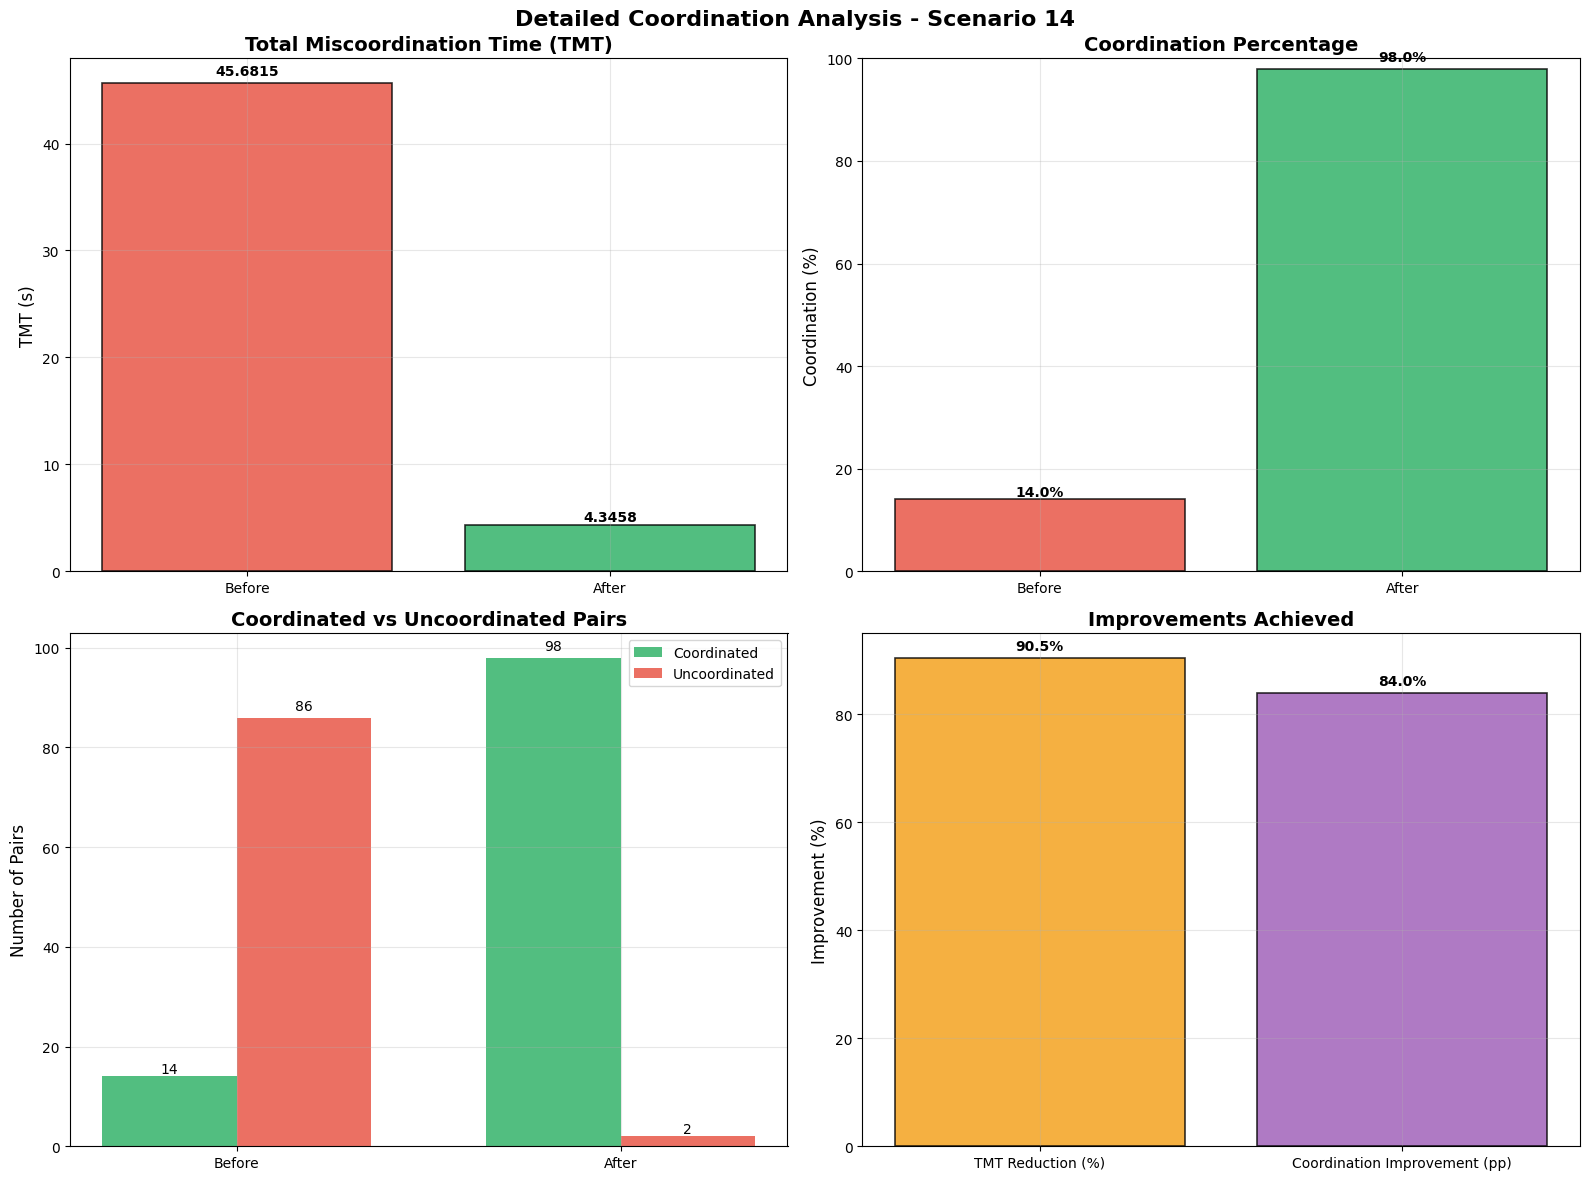


🎯 Analysis Summary - scenario_14
📊 Original State:
   🔴 TMT: 45.681500 s
   📈 Coordination: 14.00%
   ✅ Coordinated pairs: 14
   ❌ Uncoordinated pairs: 86

📊 Optimized State:
   🟢 TMT: 4.345753 s
   📈 Coordination: 98.00%
   ✅ Coordinated pairs: 98
   ❌ Uncoordinated pairs: 2

🎯 Improvements Achieved:
   📉 TMT reduction: 41.335747 s (90.49%)
   📈 Coordination improvement: 84.00 percentage points


In [6]:
# %% Comparative TMT Bar Chart - Before vs After

# Create comprehensive TMT comparison visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle(f'Detailed Coordination Analysis - {selected_scenario.replace("_", " ").title()}', 
             fontsize=16, fontweight='bold')

# 1. TMT Comparison Bar Chart
categories = ['Before', 'After'] if optimized_data else ['Original']
tmt_values = [original_tmt_magnitude, optimized_tmt_magnitude] if optimized_data else [original_tmt_magnitude]
colors = ['#e74c3c', '#27ae60'] if optimized_data else ['#e74c3c']

bars = ax1.bar(categories, tmt_values, color=colors, alpha=0.8, edgecolor='black', linewidth=1.2)
ax1.set_title('Total Miscoordination Time (TMT)', fontsize=14, fontweight='bold')
ax1.set_ylabel('TMT (s)', fontsize=12)
ax1.grid(True, alpha=0.3)

# Add value labels on bars
for bar, value in zip(bars, tmt_values):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
             f'{value:.4f}', ha='center', va='bottom', fontweight='bold')

# 2. Coordination Percentage Comparison
coord_values = [original_stats['coordination_percentage'], optimized_stats['coordination_percentage']] if optimized_data else [original_stats['coordination_percentage']]
bars2 = ax2.bar(categories, coord_values, color=colors, alpha=0.8, edgecolor='black', linewidth=1.2)
ax2.set_title('Coordination Percentage', fontsize=14, fontweight='bold')
ax2.set_ylabel('Coordination (%)', fontsize=12)
ax2.set_ylim(0, 100)
ax2.grid(True, alpha=0.3)

# Add value labels
for bar, value in zip(bars2, coord_values):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
             f'{value:.1f}%', ha='center', va='bottom', fontweight='bold')

# 3. Coordinated vs Uncoordinated Pairs
if optimized_data:
    coord_data = [original_stats['coordinated_pairs'], optimized_stats['coordinated_pairs']]
    uncoord_data = [original_stats['uncoordinated_pairs'], optimized_stats['uncoordinated_pairs']]
    
    x = np.arange(len(categories))
    width = 0.35
    
    bars3a = ax3.bar(x - width/2, coord_data, width, label='Coordinated', color='#27ae60', alpha=0.8)
    bars3b = ax3.bar(x + width/2, uncoord_data, width, label='Uncoordinated', color='#e74c3c', alpha=0.8)
    
    ax3.set_title('Coordinated vs Uncoordinated Pairs', fontsize=14, fontweight='bold')
    ax3.set_ylabel('Number of Pairs', fontsize=12)
    ax3.set_xticks(x)
    ax3.set_xticklabels(categories)
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # Add value labels
    for bars in [bars3a, bars3b]:
        for bar in bars:
            height = bar.get_height()
            ax3.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                     f'{int(height)}', ha='center', va='bottom', fontsize=10)
else:
    # Single scenario view
    coord_data = [original_stats['coordinated_pairs']]
    uncoord_data = [original_stats['uncoordinated_pairs']]
    
    x = np.arange(1)
    width = 0.35
    
    bars3a = ax3.bar(x - width/2, coord_data, width, label='Coordinated', color='#27ae60', alpha=0.8)
    bars3b = ax3.bar(x + width/2, uncoord_data, width, label='Uncoordinated', color='#e74c3c', alpha=0.8)
    
    ax3.set_title('Coordinated vs Uncoordinated Pairs', fontsize=14, fontweight='bold')
    ax3.set_ylabel('Number of Pairs', fontsize=12)
    ax3.set_xticks(x)
    ax3.set_xticklabels(['Original'])
    ax3.legend()
    ax3.grid(True, alpha=0.3)

# 4. Improvement Summary (only if optimized data available)
if optimized_data and tmt_improvement > 0:
    improvements = [tmt_improvement/original_tmt_magnitude*100, coord_improvement]
    improvement_labels = ['TMT Reduction (%)', 'Coordination Improvement (pp)']
    
    bars4 = ax4.bar(improvement_labels, improvements, color=['#f39c12', '#9b59b6'], alpha=0.8, edgecolor='black', linewidth=1.2)
    ax4.set_title('Improvements Achieved', fontsize=14, fontweight='bold')
    ax4.set_ylabel('Improvement (%)', fontsize=12)
    ax4.grid(True, alpha=0.3)
    
    # Add value labels
    for bar, value in zip(bars4, improvements):
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                 f'{value:.1f}%', ha='center', va='bottom', fontweight='bold')
else:
    # Show scenario summary if no optimization data
    summary_text = f"""
    Scenario Summary:
    
    📊 Total Pairs: {original_stats['total_pairs']}
    ✅ Coordinated: {original_stats['coordinated_pairs']}
    ❌ Uncoordinated: {original_stats['uncoordinated_pairs']}
    📈 Coordination %: {original_stats['coordination_percentage']:.2f}%
    🔴 TMT: {original_tmt_magnitude:.6f} s
    """
    
    ax4.text(0.1, 0.5, summary_text, transform=ax4.transAxes, fontsize=12,
             verticalalignment='center', bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue", alpha=0.5))
    ax4.set_title('Scenario Summary', fontsize=14, fontweight='bold')
    ax4.axis('off')

plt.tight_layout()
plt.show()

# Print summary
print(f"\n🎯 Analysis Summary - {selected_scenario}")
print("=" * 50)
print(f"📊 Original State:")
print(f"   🔴 TMT: {original_tmt_magnitude:.6f} s")
print(f"   📈 Coordination: {original_stats['coordination_percentage']:.2f}%")
print(f"   ✅ Coordinated pairs: {original_stats['coordinated_pairs']}")
print(f"   ❌ Uncoordinated pairs: {original_stats['uncoordinated_pairs']}")

if optimized_data:
    print(f"\n📊 Optimized State:")
    print(f"   🟢 TMT: {optimized_tmt_magnitude:.6f} s")
    print(f"   📈 Coordination: {optimized_stats['coordination_percentage']:.2f}%")
    print(f"   ✅ Coordinated pairs: {optimized_stats['coordinated_pairs']}")
    print(f"   ❌ Uncoordinated pairs: {optimized_stats['uncoordinated_pairs']}")
    
    print(f"\n🎯 Improvements Achieved:")
    print(f"   📉 TMT reduction: {tmt_improvement:.6f} s ({tmt_improvement/original_tmt_magnitude*100:.2f}%)")
    print(f"   📈 Coordination improvement: {coord_improvement:.2f} percentage points")



🔍 Creating detailed analysis by relay pairs...
📊 Analysis completed for 100 relay pairs
📈 Top 10 pairs with highest improvement:


,Pair,Δt_Original,Δt_Optimized,Δt_Improvement,Coord_Original,Coord_Optimized
89,R8-R7,-14.3065,1.743031,16.049531,NO,YES
41,R70-R58,-7.0415,1.383286,8.424786,NO,YES
42,R70-R20,-7.0266,0.803841,7.830441,NO,YES
86,R7-R6,-0.9588,0.828026,1.786826,NO,YES
26,R18-R1,-0.5321,-1.975973,-1.443873,NO,NO
92,R45-R71,-0.5191,inf,inf,NO,YES
91,R45-R46,-0.5191,45.964452,46.483552,NO,YES
29,R2-R1,-0.5055,-2.369780,-1.864280,NO,NO
93,R9-R8,-0.4934,inf,inf,NO,YES
94,R9-R71,-0.4934,0.516446,1.009846,NO,YES


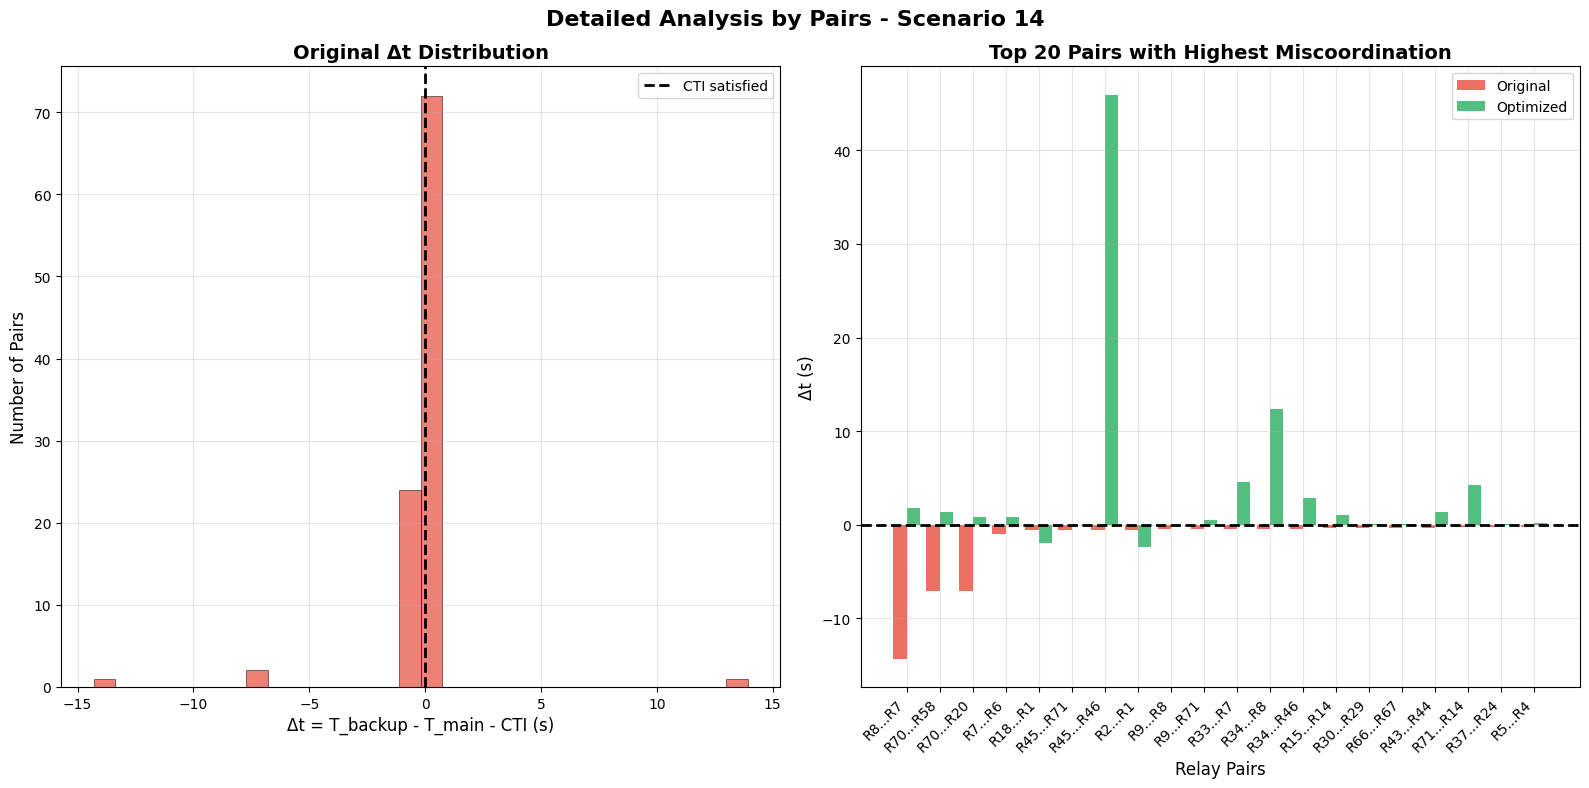


📊 Pair Analysis Statistics:
📋 Total pairs analyzed: 100
🔴 Original State:
   ✅ Coordinated: 14 (14.0%)
   ❌ Uncoordinated: 86 (86.0%)
🟢 Optimized State:
   ✅ Coordinated: 98 (98.0%)
   ❌ Uncoordinated: 2 (2.0%)
🎯 Improvements by Pair:
   📈 Improved pairs: 96 (96.0%)
   📉 Worsened pairs: 4 (4.0%)
   ➖ Unchanged pairs: 0 (0.0%)

🏆 Top 5 Best Improvements:
   R45-R71: inf s improvement
   R9-R8: inf s improvement
   R45-R46: 46.4836 s improvement
   R8-R7: 16.0495 s improvement
   R34-R8: 12.8116 s improvement


In [7]:
# %% Detailed Analysis by Relay Pairs

def create_pair_analysis_data(scenario_data, optimized_data=None):
    """Create detailed pair analysis data"""
    pairs_analysis = []
    
    # Create mapping for optimized data if available
    opt_pairs_map = {}
    if optimized_data:
        for entry in optimized_data:
            main_name = entry.get("main_relay", {}).get("relay", "").strip()
            backup_name = entry.get("backup_relay", {}).get("relay", "").strip()
            if main_name and backup_name:
                opt_pairs_map[(main_name, backup_name)] = entry
    
    # Analyze original pairs
    for entry in scenario_data:
        main_relay = entry.get("main_relay", {})
        backup_relay = entry.get("backup_relay", {})
        
        main_name = main_relay.get("relay", "").strip()
        backup_name = backup_relay.get("relay", "").strip()
        
        if not main_name or not backup_name:
            continue
        
        # Original times
        t_main_orig = main_relay.get("Time_out")
        t_backup_orig = backup_relay.get("Time_out")
        
        if t_main_orig is None or t_backup_orig is None:
            continue
        
        # Calculate original delta_t
        dt_orig = (t_backup_orig - t_main_orig) - CTI
        
        # Get optimized data if available
        opt_entry = opt_pairs_map.get((main_name, backup_name))
        t_main_opt = t_backup_opt = dt_opt = None
        
        if opt_entry:
            opt_main = opt_entry.get("main_relay", {})
            opt_backup = opt_entry.get("backup_relay", {})
            t_main_opt = opt_main.get("Time_out")
            t_backup_opt = opt_backup.get("Time_out")
            
            if t_main_opt is not None and t_backup_opt is not None:
                dt_opt = (t_backup_opt - t_main_opt) - CTI
        
        # Determine coordination status
        coord_orig = "YES" if dt_orig >= 0 else "NO"
        coord_opt = "YES" if dt_opt >= 0 else "NO" if dt_opt is not None else "N/A"
        
        # Calculate improvement
        improvement = dt_opt - dt_orig if dt_opt is not None else None
        
        pairs_analysis.append({
            "Pair": f"{main_name}-{backup_name}",
            "Main_Relay": main_name,
            "Backup_Relay": backup_name,
            "T_Main_Original": t_main_orig,
            "T_Backup_Original": t_backup_orig,
            "Δt_Original": dt_orig,
            "Coord_Original": coord_orig,
            "T_Main_Optimized": t_main_opt,
            "T_Backup_Optimized": t_backup_opt,
            "Δt_Optimized": dt_opt,
            "Coord_Optimized": coord_opt,
            "Δt_Improvement": improvement
        })
    
    return pairs_analysis

# Create detailed pair analysis
print("🔍 Creating detailed analysis by relay pairs...")
pairs_analysis = create_pair_analysis_data(scenario_data, optimized_data)

if pairs_analysis:
    # Convert to DataFrame for easier analysis
    pairs_df = pd.DataFrame(pairs_analysis)
    
    # Sort by worst original delta_t
    pairs_df_sorted = pairs_df.sort_values("Δt_Original", ascending=True)
    
    print(f"📊 Analysis completed for {len(pairs_df)} relay pairs")
    print(f"📈 Top 10 pairs with highest improvement:")
    
    # Show top improvements
    if optimized_data:
        top_improvements = pairs_df_sorted.head(10)
        display(top_improvements[["Pair", "Δt_Original", "Δt_Optimized", "Δt_Improvement", "Coord_Original", "Coord_Optimized"]])
    else:
        # Show worst 10 pairs if no optimization data
        worst_pairs = pairs_df_sorted.head(10)
        display(worst_pairs[["Pair", "Δt_Original", "Coord_Original"]])
    
    # Create visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    fig.suptitle(f'Detailed Analysis by Pairs - {selected_scenario.replace("_", " ").title()}', 
                 fontsize=16, fontweight='bold')
    
    # 1. Delta_t distribution histogram
    ax1.hist(pairs_df["Δt_Original"], bins=30, color='#e74c3c', alpha=0.7, edgecolor='black', linewidth=0.5)
    ax1.axvline(0, color='black', linestyle='--', linewidth=2, label='CTI satisfied')
    ax1.set_title('Original Δt Distribution', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Δt = T_backup - T_main - CTI (s)', fontsize=12)
    ax1.set_ylabel('Number of Pairs', fontsize=12)
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. Top 20 worst pairs comparison
    top_20 = pairs_df_sorted.head(20)
    x_pos = range(len(top_20))
    
    bars1 = ax2.bar([x - 0.2 for x in x_pos], top_20["Δt_Original"], 
                   width=0.4, label='Original', color='#e74c3c', alpha=0.8)
    
    if optimized_data:
        bars2 = ax2.bar([x + 0.2 for x in x_pos], top_20["Δt_Optimized"], 
                       width=0.4, label='Optimized', color='#27ae60', alpha=0.8)
    
    ax2.axhline(0, color='black', linestyle='--', linewidth=2)
    ax2.set_title('Top 20 Pairs with Highest Miscoordination', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Relay Pairs', fontsize=12)
    ax2.set_ylabel('Δt (s)', fontsize=12)
    ax2.set_xticks(x_pos)
    ax2.set_xticklabels([f"{pair.split('-')[0][:8]}...{pair.split('-')[1][:8]}" for pair in top_20["Pair"]], 
                       rotation=45, ha='right')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Summary statistics
    print(f"\n📊 Pair Analysis Statistics:")
    print("=" * 50)
    print(f"📋 Total pairs analyzed: {len(pairs_df)}")
    
    # Original statistics
    coord_orig = len(pairs_df[pairs_df["Coord_Original"] == "YES"])
    uncoord_orig = len(pairs_df[pairs_df["Coord_Original"] == "NO"])
    print(f"🔴 Original State:")
    print(f"   ✅ Coordinated: {coord_orig} ({coord_orig/len(pairs_df)*100:.1f}%)")
    print(f"   ❌ Uncoordinated: {uncoord_orig} ({uncoord_orig/len(pairs_df)*100:.1f}%)")
    
    if optimized_data:
        # Optimized statistics
        coord_opt = len(pairs_df[pairs_df["Coord_Optimized"] == "YES"])
        uncoord_opt = len(pairs_df[pairs_df["Coord_Optimized"] == "NO"])
        print(f"🟢 Optimized State:")
        print(f"   ✅ Coordinated: {coord_opt} ({coord_opt/len(pairs_df)*100:.1f}%)")
        print(f"   ❌ Uncoordinated: {uncoord_opt} ({uncoord_opt/len(pairs_df)*100:.1f}%)")
        
        # Improvement statistics
        improved_pairs = len(pairs_df[pairs_df["Δt_Improvement"] > 0])
        worsened_pairs = len(pairs_df[pairs_df["Δt_Improvement"] < 0])
        unchanged_pairs = len(pairs_df[pairs_df["Δt_Improvement"] == 0])
        
        print(f"🎯 Improvements by Pair:")
        print(f"   📈 Improved pairs: {improved_pairs} ({improved_pairs/len(pairs_df)*100:.1f}%)")
        print(f"   📉 Worsened pairs: {worsened_pairs} ({worsened_pairs/len(pairs_df)*100:.1f}%)")
        print(f"   ➖ Unchanged pairs: {unchanged_pairs} ({unchanged_pairs/len(pairs_df)*100:.1f}%)")
        
        # Best improvements
        best_improvements = pairs_df.nlargest(5, "Δt_Improvement")
        print(f"\n🏆 Top 5 Best Improvements:")
        for idx, row in best_improvements.iterrows():
            print(f"   {row['Pair']}: {row['Δt_Improvement']:.4f} s improvement")
    
else:
    print("❌ No valid pairs found for analysis")



🔧 Analyzing relay parameters...
📊 Analysis of 73 relays
✅ Relays with complete data: 73


,Relay,TDS_Initial,TDS_Optimized,TDS_Change,TDS_Change_%,Pickup_Initial,Pickup_Optimized,Pickup_Change,Pickup_Change_%
0,R4,0.12268,0.35823,0.23555,192.003587,0.03702,0.14130,0.10428,281.685575
1,R29,0.05000,0.44568,0.39568,791.360000,0.06258,0.23556,0.17298,276.414190
2,R39,0.13132,0.15195,0.02063,15.709717,0.04561,0.38814,0.34253,750.997588
3,R63,0.07810,0.70316,0.62506,800.332907,0.07564,0.05155,-0.02409,-31.848228
4,R12,0.13354,0.71092,0.57738,432.364835,0.03490,0.21003,0.17513,501.805158
5,R8,0.05000,0.77722,0.72722,1454.440000,0.23412,0.02082,-0.21330,-91.107125
6,R24,0.10388,0.34403,0.24015,231.180208,0.03187,0.17108,0.13921,436.805773
7,R37,0.22290,0.40620,0.18330,82.234186,0.00479,0.13097,0.12618,2634.237996
8,R11,0.09831,0.68084,0.58253,592.543993,0.08807,0.21781,0.12974,147.314636
9,R60,0.09990,0.33769,0.23779,238.028028,0.06035,0.16561,0.10526,174.415907


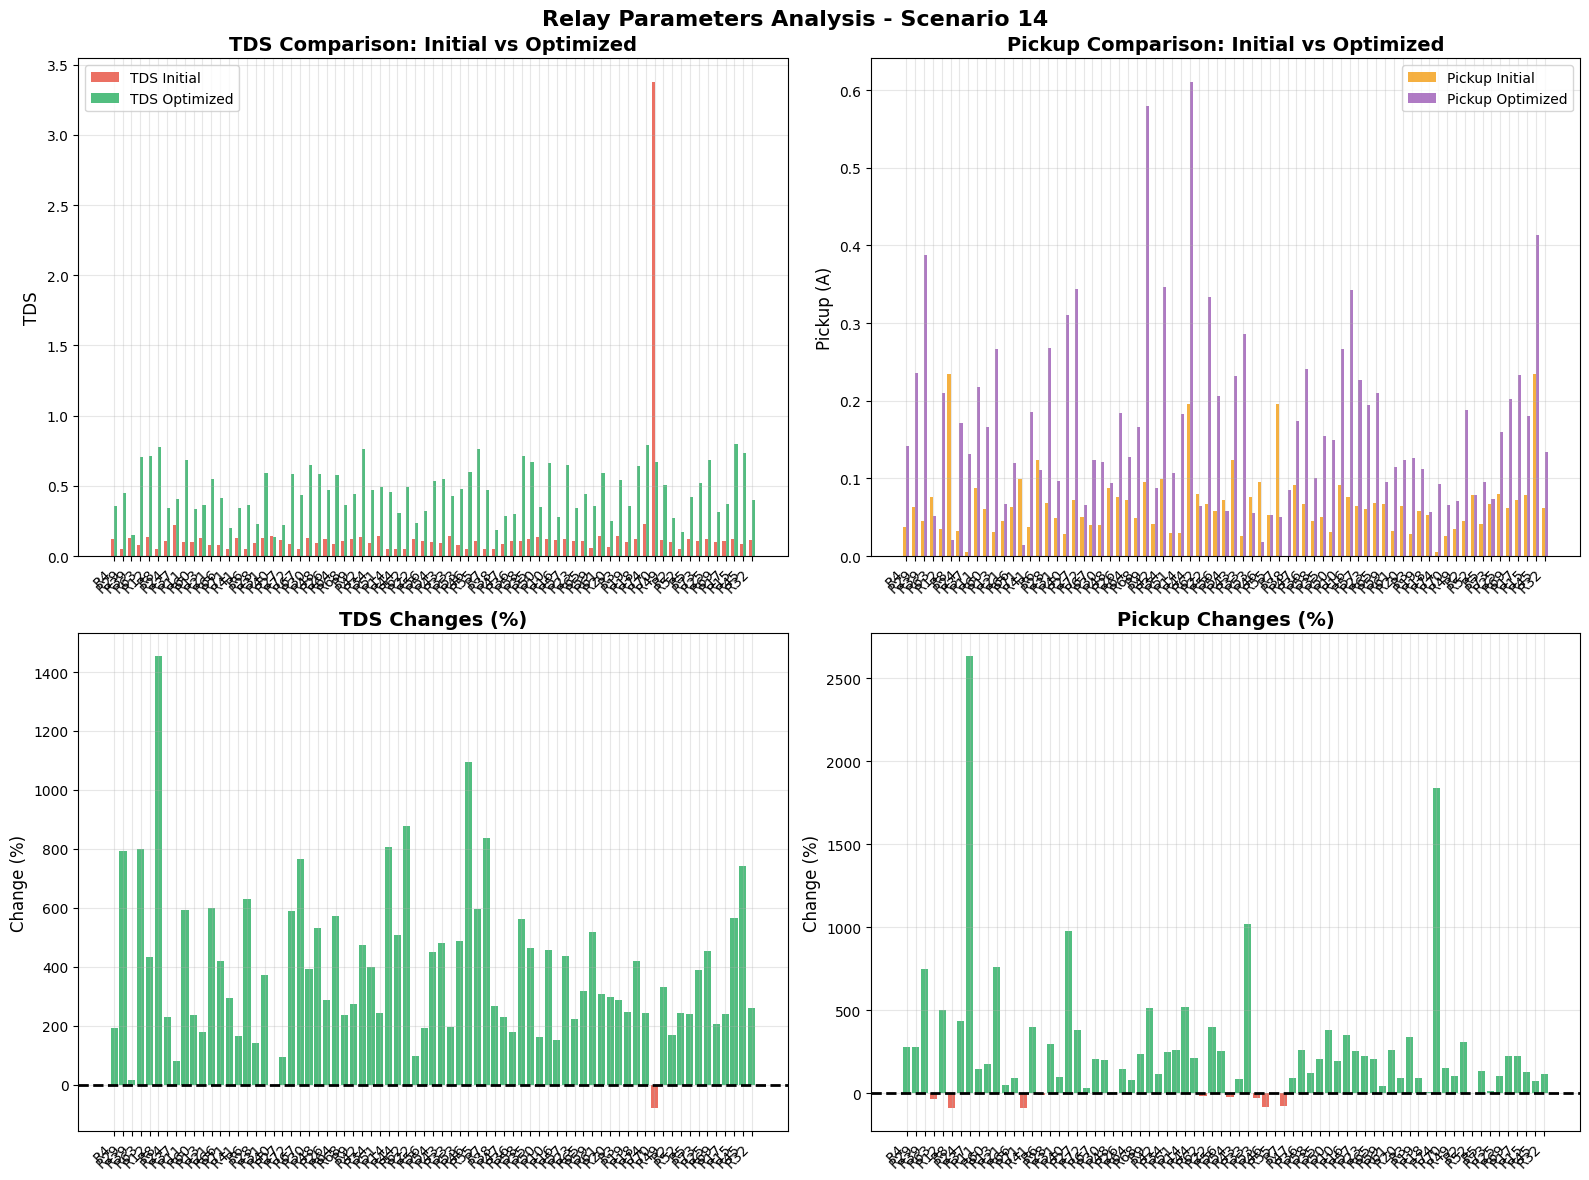


🔧 Relay Parameters Statistics:
📊 TDS:
   📈 Average change: 0.3180
   📉 Minimum change: -2.7086
   📈 Maximum change: 0.7272
   📊 Standard deviation: 0.3973
📊 Pickup:
   📈 Average change: 0.1035 A
   📉 Minimum change: -0.2133 A
   📈 Maximum change: 0.4846 A
   📊 Standard deviation: 0.1142 A

🏆 Top 5 Most Significant Changes:
TDS:
   R8: 1454.44%
   R46: 1093.38%
   R62: 876.60%
   R7: 838.06%
   R14: 805.78%
Pickup:
   R37: 2634.24%
   R74: 1837.16%
   R33: 1018.09%
   R40: 979.73%
   R13: 762.58%


In [8]:
# %% Relay Parameters Analysis (TDS and Pickup)

def analyze_relay_parameters(scenario_info, optimized_values):
    """Analyze relay parameters before and after optimization"""
    relay_analysis = []
    
    for relay_name in scenario_info['relays']:
        # Get initial settings
        initial_settings = scenario_info['initial_settings'].get(relay_name, {})
        tds_initial = initial_settings.get('TDS_initial')
        pickup_initial = initial_settings.get('pickup_initial')
        
        # Get optimized settings
        optimized_relay = optimized_values.get(relay_name, {})
        tds_optimized = optimized_relay.get('TDS')
        pickup_optimized = optimized_relay.get('pickup')
        
        # Calculate changes
        tds_change = tds_optimized - tds_initial if (tds_optimized is not None and tds_initial is not None) else None
        pickup_change = pickup_optimized - pickup_initial if (pickup_optimized is not None and pickup_initial is not None) else None
        
        tds_change_pct = (tds_change / tds_initial * 100) if (tds_change is not None and tds_initial is not None and tds_initial != 0) else None
        pickup_change_pct = (pickup_change / pickup_initial * 100) if (pickup_change is not None and pickup_initial is not None and pickup_initial != 0) else None
        
        relay_analysis.append({
            'Relay': relay_name,
            'TDS_Initial': tds_initial,
            'TDS_Optimized': tds_optimized,
            'TDS_Change': tds_change,
            'TDS_Change_%': tds_change_pct,
            'Pickup_Initial': pickup_initial,
            'Pickup_Optimized': pickup_optimized,
            'Pickup_Change': pickup_change,
            'Pickup_Change_%': pickup_change_pct
        })
    
    return relay_analysis

# Analyze relay parameters
print("🔧 Analyzing relay parameters...")
relay_analysis = analyze_relay_parameters(scenario_info, optimized_values)

if relay_analysis:
    relay_df = pd.DataFrame(relay_analysis)
    
    # Show summary of relay parameters
    print(f"📊 Analysis of {len(relay_df)} relays")
    
    # Filter out relays with missing data
    complete_relays = relay_df.dropna(subset=['TDS_Optimized', 'Pickup_Optimized'], how='all')
    
    if not complete_relays.empty:
        print(f"✅ Relays with complete data: {len(complete_relays)}")
        display(complete_relays.head(15))
        
        # Create relay parameters visualization
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
        fig.suptitle(f'Relay Parameters Analysis - {selected_scenario.replace("_", " ").title()}', 
                     fontsize=16, fontweight='bold')
        
        # 1. TDS Comparison
        x_pos = range(len(complete_relays))
        width = 0.35
        
        bars1a = ax1.bar([x - width/2 for x in x_pos], complete_relays['TDS_Initial'], 
                        width, label='TDS Initial', color='#e74c3c', alpha=0.8)
        bars1b = ax1.bar([x + width/2 for x in x_pos], complete_relays['TDS_Optimized'], 
                        width, label='TDS Optimized', color='#27ae60', alpha=0.8)
        
        ax1.set_title('TDS Comparison: Initial vs Optimized', fontsize=14, fontweight='bold')
        ax1.set_ylabel('TDS', fontsize=12)
        ax1.set_xticks(x_pos)
        ax1.set_xticklabels([name[:15] + '...' if len(name) > 15 else name for name in complete_relays['Relay']], 
                           rotation=45, ha='right')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # 2. Pickup Comparison
        bars2a = ax2.bar([x - width/2 for x in x_pos], complete_relays['Pickup_Initial'], 
                        width, label='Pickup Initial', color='#f39c12', alpha=0.8)
        bars2b = ax2.bar([x + width/2 for x in x_pos], complete_relays['Pickup_Optimized'], 
                        width, label='Pickup Optimized', color='#9b59b6', alpha=0.8)
        
        ax2.set_title('Pickup Comparison: Initial vs Optimized', fontsize=14, fontweight='bold')
        ax2.set_ylabel('Pickup (A)', fontsize=12)
        ax2.set_xticks(x_pos)
        ax2.set_xticklabels([name[:15] + '...' if len(name) > 15 else name for name in complete_relays['Relay']], 
                           rotation=45, ha='right')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        # 3. TDS Changes Percentage
        tds_changes = complete_relays['TDS_Change_%'].dropna()
        if not tds_changes.empty:
            colors_tds = ['#27ae60' if x > 0 else '#e74c3c' for x in tds_changes]
            bars3 = ax3.bar(range(len(tds_changes)), tds_changes, color=colors_tds, alpha=0.8)
            ax3.axhline(0, color='black', linestyle='--', linewidth=2)
            ax3.set_title('TDS Changes (%)', fontsize=14, fontweight='bold')
            ax3.set_ylabel('Change (%)', fontsize=12)
            ax3.set_xticks(range(len(tds_changes)))
            ax3.set_xticklabels([name[:15] + '...' if len(name) > 15 else name for name in complete_relays.loc[tds_changes.index, 'Relay']], 
                               rotation=45, ha='right')
            ax3.grid(True, alpha=0.3)
        
        # 4. Pickup Changes Percentage
        pickup_changes = complete_relays['Pickup_Change_%'].dropna()
        if not pickup_changes.empty:
            colors_pickup = ['#27ae60' if x > 0 else '#e74c3c' for x in pickup_changes]
            bars4 = ax4.bar(range(len(pickup_changes)), pickup_changes, color=colors_pickup, alpha=0.8)
            ax4.axhline(0, color='black', linestyle='--', linewidth=2)
            ax4.set_title('Pickup Changes (%)', fontsize=14, fontweight='bold')
            ax4.set_ylabel('Change (%)', fontsize=12)
            ax4.set_xticks(range(len(pickup_changes)))
            ax4.set_xticklabels([name[:15] + '...' if len(name) > 15 else name for name in complete_relays.loc[pickup_changes.index, 'Relay']], 
                               rotation=45, ha='right')
            ax4.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Summary statistics
        print(f"\n🔧 Relay Parameters Statistics:")
        print("=" * 50)
        
        # TDS statistics
        tds_changes_valid = complete_relays['TDS_Change'].dropna()
        if not tds_changes_valid.empty:
            print(f"📊 TDS:")
            print(f"   📈 Average change: {tds_changes_valid.mean():.4f}")
            print(f"   📉 Minimum change: {tds_changes_valid.min():.4f}")
            print(f"   📈 Maximum change: {tds_changes_valid.max():.4f}")
            print(f"   📊 Standard deviation: {tds_changes_valid.std():.4f}")
        
        # Pickup statistics
        pickup_changes_valid = complete_relays['Pickup_Change'].dropna()
        if not pickup_changes_valid.empty:
            print(f"📊 Pickup:")
            print(f"   📈 Average change: {pickup_changes_valid.mean():.4f} A")
            print(f"   📉 Minimum change: {pickup_changes_valid.min():.4f} A")
            print(f"   📈 Maximum change: {pickup_changes_valid.max():.4f} A")
            print(f"   📊 Standard deviation: {pickup_changes_valid.std():.4f} A")
        
        # Top changes
        print(f"\n🏆 Top 5 Most Significant Changes:")
        print("TDS:")
        top_tds_changes = complete_relays.nlargest(5, 'TDS_Change_%')[['Relay', 'TDS_Change_%']]
        for idx, row in top_tds_changes.iterrows():
            print(f"   {row['Relay']}: {row['TDS_Change_%']:.2f}%")
        
        print("Pickup:")
        top_pickup_changes = complete_relays.nlargest(5, 'Pickup_Change_%')[['Relay', 'Pickup_Change_%']]
        for idx, row in top_pickup_changes.iterrows():
            print(f"   {row['Relay']}: {row['Pickup_Change_%']:.2f}%")
    
    else:
        print("⚠️  No complete parameter data available to display")
else:
    print("❌ No relay parameter data found")



In [9]:
# %% Final Summary and Conclusions

print("🎯 FINAL ANALYSIS SUMMARY")
print("=" * 60)
print(f"📊 Analyzed Scenario: {selected_scenario}")
print(f"📅 Analysis Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"⚙️  Coordination Parameters: CTI = {CTI}s, K = {K}, N = {N}")
print()

print("📈 MAIN RESULTS:")
print("-" * 40)

# Original scenario summary
print(f"🔴 Original State:")
print(f"   📊 Total pairs: {original_stats['total_pairs']}")
print(f"   ✅ Coordinated pairs: {original_stats['coordinated_pairs']} ({original_stats['coordination_percentage']:.2f}%)")
print(f"   ❌ Uncoordinated pairs: {original_stats['uncoordinated_pairs']}")
print(f"   🔴 TMT (magnitude): {original_tmt_magnitude:.6f} s")
print(f"   🔴 TMT (signed): {original_tmt_signed:.6f} s")

if optimized_data:
    print()
    print(f"🟢 Optimized State:")
    print(f"   📊 Total pairs: {optimized_stats['total_pairs']}")
    print(f"   ✅ Coordinated pairs: {optimized_stats['coordinated_pairs']} ({optimized_stats['coordination_percentage']:.2f}%)")
    print(f"   ❌ Uncoordinated pairs: {optimized_stats['uncoordinated_pairs']}")
    print(f"   🟢 TMT (magnitude): {optimized_tmt_magnitude:.6f} s")
    print(f"   🟢 TMT (signed): {optimized_tmt_signed:.6f} s")
    
    print()
    print(f"🎯 IMPROVEMENTS ACHIEVED:")
    print(f"   📉 TMT reduction: {tmt_improvement:.6f} s ({tmt_improvement/original_tmt_magnitude*100:.2f}%)")
    print(f"   📈 Coordination improvement: {coord_improvement:.2f} percentage points")
    print(f"   🏆 Additional coordinated pairs: {optimized_stats['coordinated_pairs'] - original_stats['coordinated_pairs']}")
    
    # Calculate efficiency metrics
    if original_stats['total_pairs'] > 0:
        coordination_efficiency = optimized_stats['coordination_percentage'] / original_stats['coordination_percentage']
        print(f"   📊 Coordination efficiency: {coordination_efficiency:.2f}x")
        
        tmt_reduction_efficiency = tmt_improvement / original_tmt_magnitude if original_tmt_magnitude > 0 else 0
        print(f"   📉 TMT reduction efficiency: {tmt_reduction_efficiency:.2f}")

print()
print("🔧 RELAY ANALYSIS:")
print("-" * 40)
print(f"   📊 Total unique relays: {len(scenario_info['relays'])}")
print(f"   ⚙️  Relays with initial parameters: {len(scenario_info['initial_settings'])}")

if optimized_values:
    print(f"   🎯 Optimized relays: {len(optimized_values)}")
    
    # Relay optimization summary
    optimized_relays = len(optimized_values)
    total_relays = len(scenario_info['relays'])
    optimization_coverage = (optimized_relays / total_relays * 100) if total_relays > 0 else 0
    print(f"   📈 Optimization coverage: {optimization_coverage:.1f}%")

print()
print("📊 PAIR ANALYSIS:")
print("-" * 40)
if 'pairs_df' in locals() and not pairs_df.empty:
    print(f"   📋 Analyzed pairs: {len(pairs_df)}")
    
    if optimized_data:
        improved_pairs = len(pairs_df[pairs_df["Δt_Improvement"] > 0])
        worsened_pairs = len(pairs_df[pairs_df["Δt_Improvement"] < 0])
        unchanged_pairs = len(pairs_df[pairs_df["Δt_Improvement"] == 0])
        
        print(f"   📈 Improved pairs: {improved_pairs} ({improved_pairs/len(pairs_df)*100:.1f}%)")
        print(f"   📉 Worsened pairs: {worsened_pairs} ({worsened_pairs/len(pairs_df)*100:.1f}%)")
        print(f"   ➖ Unchanged pairs: {unchanged_pairs} ({unchanged_pairs/len(pairs_df)*100:.1f}%)")
        
        # Best and worst improvements
        best_improvement = pairs_df["Δt_Improvement"].max()
        worst_improvement = pairs_df["Δt_Improvement"].min()
        print(f"   🏆 Best individual improvement: {best_improvement:.4f} s")
        print(f"   ⚠️  Worst individual change: {worst_improvement:.4f} s")

print()
print("🎯 CONCLUSIONS:")
print("-" * 40)

if optimized_data:
    if tmt_improvement > 0:
        print("✅ Genetic algorithm optimization was SUCCESSFUL:")
        print(f"   • TMT reduced by {tmt_improvement:.6f} seconds")
        print(f"   • Coordination improved by {coord_improvement:.2f} percentage points")
        print(f"   • {optimized_stats['coordinated_pairs'] - original_stats['coordinated_pairs']} additional pairs coordinated")
        
        if coord_improvement > 0:
            print("✅ Overall system coordination improved significantly")
        else:
            print("⚠️  Overall coordination did not improve, but TMT was reduced")
    else:
        print("⚠️  Optimization did not produce significant TMT improvements")
    
    if original_stats['coordination_percentage'] < 50:
        print("🔴 Original scenario had poor coordination")
    elif original_stats['coordination_percentage'] < 80:
        print("🟡 Original scenario had moderate coordination")
    else:
        print("🟢 Original scenario already had good coordination")
else:
    print("📊 Original scenario analysis completed")
    print(f"   • Scenario shows {original_stats['coordination_percentage']:.1f}% coordination")
    if original_stats['coordination_percentage'] < 70:
        print("   • Optimization recommended to improve coordination")
    else:
        print("   • Scenario has acceptable coordination")

print()
print("📁 FILES AND DATA:")
print("-" * 40)
print(f"   📂 Selected scenario: {selected_scenario}")
print(f"   📊 Original data: {len(scenario_data)} entries")
if optimized_data:
    print(f"   🎯 Optimized data: {len(optimized_data)} entries")
    print(f"   ⚙️  Optimized parameters: {len(optimized_values)} relays")
print(f"   📈 Analyzed pairs: {len(scenario_info['pairs'])}")

print()
print("🏁 ANALYSIS COMPLETED SUCCESSFULLY")
print("=" * 60)



🎯 FINAL ANALYSIS SUMMARY
📊 Analyzed Scenario: scenario_14
📅 Analysis Date: 2025-10-10 16:31:04
⚙️  Coordination Parameters: CTI = 0.2s, K = 0.14, N = 0.02

📈 MAIN RESULTS:
----------------------------------------
🔴 Original State:
   📊 Total pairs: 100
   ✅ Coordinated pairs: 14 (14.00%)
   ❌ Uncoordinated pairs: 86
   🔴 TMT (magnitude): 45.681500 s
   🔴 TMT (signed): -45.681500 s

🟢 Optimized State:
   📊 Total pairs: 100
   ✅ Coordinated pairs: 98 (98.00%)
   ❌ Uncoordinated pairs: 2
   🟢 TMT (magnitude): 4.345753 s
   🟢 TMT (signed): -4.345753 s

🎯 IMPROVEMENTS ACHIEVED:
   📉 TMT reduction: 41.335747 s (90.49%)
   📈 Coordination improvement: 84.00 percentage points
   🏆 Additional coordinated pairs: 84
   📊 Coordination efficiency: 7.00x
   📉 TMT reduction efficiency: 0.90

🔧 RELAY ANALYSIS:
----------------------------------------
   📊 Total unique relays: 73
   ⚙️  Relays with initial parameters: 73
   🎯 Optimized relays: 73
   📈 Optimization coverage: 100.0%

📊 PAIR ANALYSIS:
----